In this post, I'll show how to interface an NILM algorithm written in Matlab with nilmtk. I'll be using the code provided by the authors of the [Infinite Factorial Dynamical Model](http://papers.nips.cc/paper/5667-infinite-factorial-dynamical-model.pdf) paper presented at [NIPS 2015](https://nips.cc/). The authors have kindly made their [code](https://github.com/franrruiz/iFDM) available on Github. I had a conversation with them and they modified the code so that it can be easily interfaced with nilmk.

Since the code is written in Matlab, we need to install some package that allows communication between Python and Matlab. The Matlab engine for Python would have been a perfect choice given that it is supported by Matlab. However, I had tough luck getting it to work on my system. Instead, I ended up using [pymatbridge](https://arokem.github.io/python-matlab-bridge/). Not only does pymatbridge provide the ability to communicate between the two languages, it also comes with a handy IPython extension that I'll be using in this post.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

import pymatbridge as pymat

%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-a6bdb861-8a5e-4a5c-90c0-ea7c9facb962
Send 'exit' command to kill the server
.......MATLAB started and connected!


Now, I have a Matlab session started.

I'll be using the REDD data set for illustration. I'll disaggregate the first day from House #1. Also, we'll be disaggregating the lights, fridge, dish washer, microwave.

In [3]:
from nilmtk import *

In [4]:
ds = DataSet("/data/REDD/redd.h5")

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/tables/__init__.py:82: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from tables.utilsextension import (
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/tables/file.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from tables import hdf5extension
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/tables/link.py:32: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from tables import linkextension
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/tables/table.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from tables import tableextension
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/tables/index.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from tables import indexesextension


Getting the `elec` for the first house.

In [5]:
elec = ds.buildings[1].elec

Setting the time window for our analysis.

In [6]:
ds.set_window("2011-04-19", "2011-04-20")

Creating a Pandas dataframe of the appliances we are interested in, along with the mains. We will be summing up all the lights instances.

In [9]:
appliances = {'mains':elec.mains(),
             'fridge':elec['fridge'],
             'dish washer':elec['dish washer'],
             'microwave':elec['microwave'],
             'light':MeterGroup([elec['light',1], elec['light',2], elec['light',3]])}

We'll  be downsampling the data to 30 seconds by median filter.

In [10]:
data = {}
for appliance_name, appliance_el  in appliances.iteritems():
    print appliance_name
    data[appliance_name] = next(appliance_el.load(sample_period=30, resample_kwargs = {"how":"median"}))
    if appliance_name =="mains":
           data[appliance_name] = data[appliance_name][('power','apparent')]
    else:
        data[appliance_name] = data[appliance_name][('power','active')]

dish washer
mains
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
fridge
microwave
light
Loading data for meter ElecMeterID(instance=18, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


Creating the dataframe.

In [11]:
data_df = pd.DataFrame(data)[["mains","fridge","light","dish washer", "microwave"]].dropna()

In [12]:
data_df.head()

,mains,fridge,light,dish washer,microwave
2011-04-19 00:00:00-04:00,190.699997,7,82,0,4
2011-04-19 00:00:30-04:00,191.434998,7,83,0,4
2011-04-19 00:01:00-04:00,190.529999,6,83,0,4
2011-04-19 00:01:30-04:00,191.619995,7,83,0,4
2011-04-19 00:02:00-04:00,192.069992,7,83,0,4


In [13]:
data_df.describe()

,mains,fridge,light,dish washer,microwave
count,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000
mean,295.715698,47.881500,111.082466,0.013930,20.370171
std,252.303360,77.789963,51.122974,0.116826,156.773621
min,168.059998,6.000000,66.000000,0.000000,2.000000
25%,175.342499,6.000000,83.000000,0.000000,4.000000
50%,246.055000,6.000000,84.000000,0.000000,4.000000
75%,353.608734,7.000000,122.000000,0.000000,4.000000
max,3388.339844,233.000000,408.000000,1.000000,1586.000000


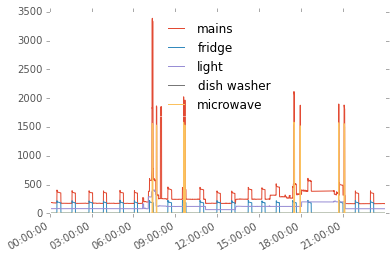

In [15]:
data_df.plot()

### Interface requirements

The reason we chose to create a dataframe in this format is that we tried to keep a simple interface between Matlab and Python. We chose the following interface:

1. The input to the Matlab method should be a .mat where the rows correpond to different appliances and the columns correpsond to time. The first row should correspond to the mains (aggregate).
2. The output from the Matlab method should be a .mat where the rows correspond to the disaggregated time series data with columns correpsonding to time.
3. Any additional arguments to the Matlab disaggregation method should be a JSON file.

So, based on these requirements, the Matlab function had the following signature

```Matlab
function power_disaggregation(input_file, output_file, config_file)
%
% This function applies the iFDM model [1] for power disaggregation.
% 
% Usage:
%     power_disaggregation(input_file, output_file [, config_file])
% 
%  +input_file: Path to the input file. It should contain a matrix in which
%   the first row corresponds to the observations (aggregated signal),
%   while the rest of the rows correspond to the individual consuption of
%   the devices. The number of columns of the matrix corresponds to the
%   number of time steps.
% 
%  +output_file: Path to the output file. Two variables are saved in the
%   output file, detailed below. Warning: These results correspond to the
%   last iteration of the sampler, they have not been averaged over several
%   iterations.
%   -acc: The resulting accuracy.
%   -output: The inferred disaggregated signals, sorted to match the input.
% 
%  +config_file: Path to a JSON configuration file (optional). 
```

So, we are all set. We'll have a look at the first few lines of the parameters passed to the disaggregation method. 

In [16]:
!head /Users/nipunbatra/git/iFDM/PowerDisaggregation/parameters.json

 {
     "Q": 4,
     "Niter": 1000,
     "verboseCycle": 10,
     "pgas":
     {
         "N_PG": 1000,
         "Niter": 1,
         "maxM": 40
     },


The authors suggested that the data should be scaled such that the aggregate power is in 10s. So, they suggested a scaling down factor of 100, which I'll do next.

In [17]:
scaled_data_df = data_df.div(100)

Now, we'll get the matrix representation from the dataframe and store in a .mat.

In [18]:
import scipy.io as sio

In [19]:
sio.savemat("/Users/nipunbatra/git/iFDM/PowerDisaggregation/redd_data_nilmtk_1.mat",{"X":scaled_data_df.T.values})

In [21]:
cd ~/git/iFDM/PowerDisaggregation/

/Users/nipunbatra/git/iFDM/PowerDisaggregation


Finally, I'll call the Matlab method for disaggregation on the data we've produced using nilmtk.

In [20]:
%%matlab
cd('/Users/nipunbatra/git/iFDM/PowerDisaggregation/');
pwd;
power_disaggregation('redd_data_nilmtk_1.mat','output_nilmtk.mat', 'parameters.json' )

In [22]:
out = sio.loadmat("/Users/nipunbatra/git/iFDM/PowerDisaggregation/output_nilmtk.mat")
disag_df = out['output']

In [23]:
disag_df = pd.DataFrame(disag_df).T
disag_df.columns = data_df.columns[1:]
disag_df.index = data_df.index

# Scaling back up by a factor of 100
disag_df = disag_df.mul(100)

Creating dataframes for appliances to compare the ground truth and the disaggregated streams.

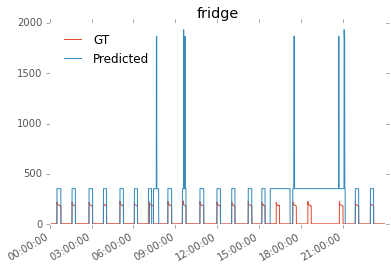

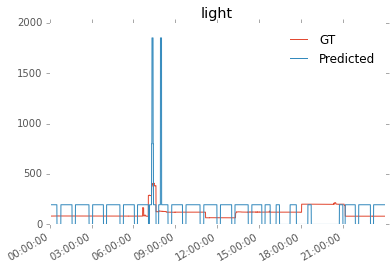

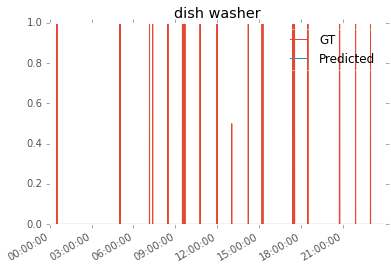

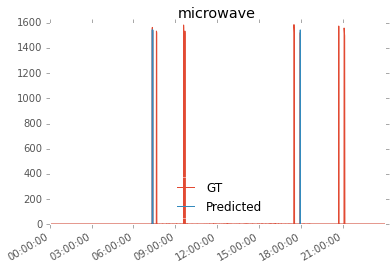

In [24]:
appliance_dfs = {}
for appliance in ['fridge', 'light', 'dish washer','microwave']:
    appliance_dfs[appliance] = pd.DataFrame({"GT":data_df[appliance],"Predicted":disag_df[appliance]})
    appliance_dfs[appliance].plot(title=appliance)

There you go! We have a working interface to the Matlab iFDM NILM algorithm. It should be noted that the program over 1000 iterations took several hours to run. I think that speedups upto 2 orders of magnitude should be possible by compiling it using `mex-setup`. I'll get onto that in a while. Another thing to note is that the disaggregated fridge power signal matches the state changes observed in the ground truth signal. However, the predicted seems to have a higher magniutde than the ground truth. This can possibly be due to the fact that the aggregate measures apparent power and the appliance meters measure active power.

I think that this small demo shows that it is straight forward to interface a Matlab NILM algorithm with nilmtk. Hope to get more such state-of-the-art algorithms interfaced with nilmtk soon.